#### importing libraries and creating new VIs for the testbench ####

In [1]:
#import libraries for the program
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
import serial
from time import sleep

rm = pyvisa.ResourceManager()
print(rm.list_resources())
#create new VIs for the tools
oscilloscope = rm.open_resource('USB0::0x0957::0x1790::MY56270939::INSTR',write_termination= '\n', read_termination='\n')
#print the identifier of the VIs available
print(oscilloscope.query('*IDN?'))


#connect throu serial with the power supply
pwr_supply = serial.Serial(port='COM4',baudrate=115200)  # open serial port
print(pwr_supply.name)
new_voltage=2.356
print(f"set voltage to {round(new_voltage,2)}")
instruction=f'VOLT {new_voltage}\n'
pwr_supply.write(instruction.encode('UTF-8')) #write data to the output of the power supply
sleep(0.5)  # Wait for change in the outptu voltage
pwr_supply.write(b'MEAS:VOLT?\n')  # Query the measured voltage
sleep(0.5)  # Wait for the response
measured_voltage = pwr_supply.readline().strip()
print(f"Measured Voltage: {measured_voltage.decode()} V")
pwr_supply.close()

('USB0::0x0957::0x1790::MY56270939::INSTR', 'ASRL4::INSTR')
AGILENT TECHNOLOGIES,MSO-X 6004A,MY56270939,06.12.2016010702
COM4
set voltage to 2.36
Measured Voltage: 2.330 V


#### parameters for the oscilloscope, still under construction ####

In [8]:
#:CHANnel1:RANGe? query returns the current full-scale range setting for the specified channel
#vertical_v_square=float(oscilloscope.query(":CHANnel1:RANGe?"))/8 #voltage value for each vertical square

#:CHANnel1:SCALe? returs the vertical scale, or units per division, of the selected channel.
vertical_v_scale=float(oscilloscope.query(":CHANnel1:SCALe?"))
print(vertical_v_scale)
#:TIMebase:SCALe? returs the horizontal scale, or time per division, of the selected channel.
horizontal_timescale=float(oscilloscope.query(":TIMebase:SCAle?"))
print(horizontal_timescale)

1.0
0.05


64516


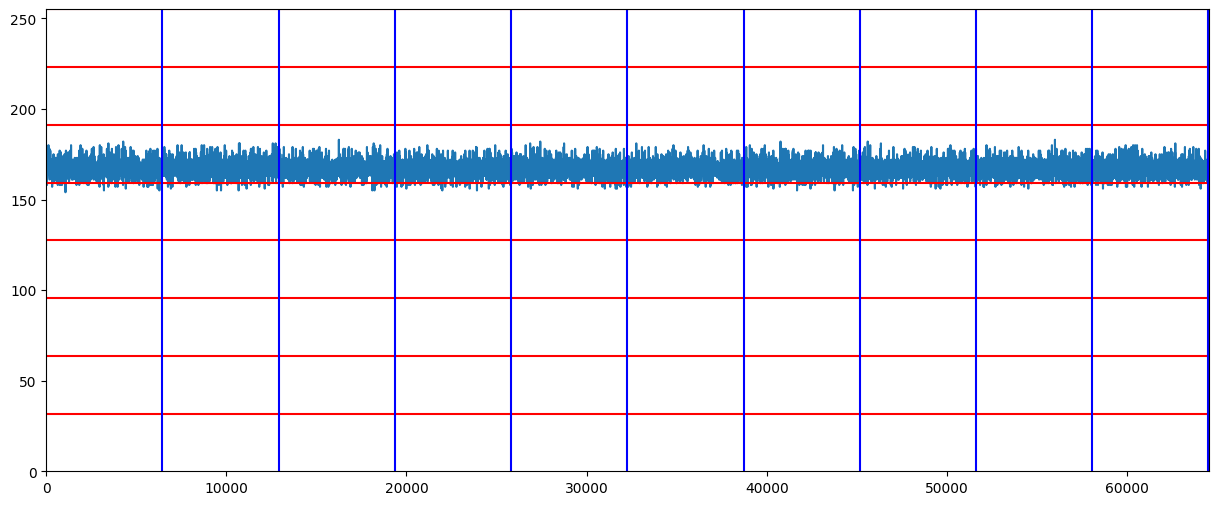

In [9]:

oscilloscope.write("*CLS")#*CLS clears the status data structures, the device-defined error queue, and the Request-for-OPC flag.
#oscilloscope.write(":ACQuire:TYPE AVERage") #modify the tyoe of acquisition of the oscilloscope to average
#oscilloscope.write(":ACQuire:COUNt 1") # number of samples to take for the average
oscilloscope.write(":RUN")
sleep(5)
oscilloscope.write(":ACQuire:TYPE NORMal") #modify the tyoe of acquisition of the oscilloscope to normal

sampling_points=80000
oscilloscope.write("WAVeform:SOURce CHANnel1") #set the source of the waveform to channel 1
oscilloscope.write("WAVeform:FORMat WORD") #set the format of the information to word
oscilloscope.write(f"WAVeform:POINts {sampling_points}") # sets the desired number of analog channel waveform points to be transferred
oscilloscope.write(":STOP")
values=oscilloscope.query_binary_values(":WAVeform:DATA?",datatype="h",container=np.array) #acquiere binary data from the oscilloscope, decode it and parse it to a numpy array
#the data is parsed as a word, or ascii, returning data with a maximum size of 8bits=255 max value
#this has an impact on how to represent the positive and negative numbers
#the oscilloscope return the lowest voltage as a 0 and the highest as 255
#the 2's complement or change in the voltage is done in software not by the oscilloscope

#take the lenght of the read values and divide it in 10 equal chuncks, each one represents a unit of time
#The oscilloscope has 10 horizontal squares for measurements
hor_points=int(len(values)/10) #calculate the lenght for each square in the time axis

#plot the acquiered data
plt.figure(figsize=(15,6))
plt.plot(values)
for a in range(1,9):
    plt.axhline(y = ((255*a)/8), color = 'r', linestyle = '-')
for a in range(1,11):
    plt.axvline(x = (hor_points*a), color = 'b', linestyle = '-')
plt.xlim([0,len(values)])
plt.ylim([0,255])
print(len(values))


#### Loop for the change in the voltage value (current) and measurement of the waveform ####

In [10]:
output_voltage=np.arange(2.37,4.1,0.01) #array for the voltage, starting at 0v, ending at 3.2v and a step of 0.05v
saved_v=[]
saved_dat=[]

#set the voltage vertical scale
oscilloscope.write(":CHANnel1:SCALe 1")
#set the horizontal time scale to 50ms
oscilloscope.write(":TIMebase:SCAle 0.05")
#se tiene que cambiar el timerange de la señal para que acomode a las señales mas lentas, 
print(oscilloscope.query(":TIMebase:RANGe?")) #query for the full-scale range time scale of the oscilloscope


for a in output_voltage:
    pwr_supply = serial.Serial(port='COM4',baudrate=115200)  # open serial port
    pwr_supply.write(b'VOLT 0\n')
    sleep(15)
    print(f"set voltage to {round(a,2)}")
    instruction=f'VOLT {a}\n'
    pwr_supply.write(instruction.encode('UTF-8')) #write data to the output of the power supply
    sleep(0.5)  # Wait for change in the outptu voltage
    pwr_supply.write(b'MEAS:VOLT?\n')  # Query the measured voltage
    sleep(0.5)  # Wait for the response
    measured_voltage = pwr_supply.readline().strip()
    print(f"Measured Voltage: {measured_voltage.decode()} V")
    pwr_supply.close()
    saved_v.append(measured_voltage)

    sleep(10)
    print('start signal aquisition')
    oscilloscope.write("*CLS")#*CLS clears the status data structures, the device-defined error queue, and the Request-for-OPC flag.
    #oscilloscope.write(":ACQuire:TYPE AVERage") #modify the tyoe of acquisition of the oscilloscope to average
    #oscilloscope.write(":ACQuire:COUNt 1") # number of samples to take for the average
    oscilloscope.write(":RUN")
    sleep(5)
    oscilloscope.write(":ACQuire:TYPE NORMal") #modify the tyoe of acquisition of the oscilloscope to normal
    sampling_points=80000
    oscilloscope.write("WAVeform:SOURce CHANnel1") #set the source of the waveform to channel 1
    oscilloscope.write("WAVeform:FORMat WORD") #set the format of the information to word
    oscilloscope.write(f"WAVeform:POINts {sampling_points}") # sets the desired number of analog channel waveform points to be transferred
    oscilloscope.write(":STOP")
    values=oscilloscope.query_binary_values(":WAVeform:DATA?",datatype="h",container=np.array) #acquiere binary data from the oscilloscope, decode it and parse it to a numpy array
    
    saved_dat.append(values)
    #plt.figure(figsize=(15,6))
    #plt.plot(values)
    #print(len(values))
    #waiting=input('press any key to continue to measure')
    sleep(0.5)

+500.0E-03
set voltage to 2.37
Measured Voltage: 2.340 V
start signal aquisition
set voltage to 2.38
Measured Voltage: 2.350 V
start signal aquisition
set voltage to 2.39
Measured Voltage: 2.360 V
start signal aquisition
set voltage to 2.4
Measured Voltage: 2.370 V
start signal aquisition
set voltage to 2.41
Measured Voltage: 2.380 V
start signal aquisition
set voltage to 2.42
Measured Voltage: 2.390 V
start signal aquisition
set voltage to 2.43
Measured Voltage: 2.410 V
start signal aquisition
set voltage to 2.44
Measured Voltage: 2.420 V
start signal aquisition
set voltage to 2.45
Measured Voltage: 2.430 V
start signal aquisition
set voltage to 2.46
Measured Voltage: 2.440 V
start signal aquisition
set voltage to 2.47
Measured Voltage: 2.450 V
start signal aquisition
set voltage to 2.48
Measured Voltage: 2.460 V
start signal aquisition
set voltage to 2.49
Measured Voltage: 2.470 V
start signal aquisition
set voltage to 2.5
Measured Voltage: 2.480 V
start signal aquisition
set voltage

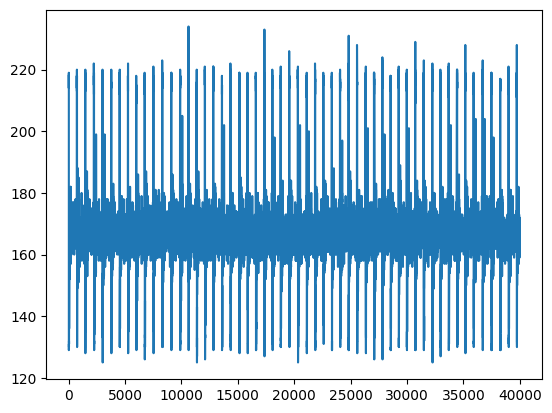

In [14]:
plt.plot(saved_dat[10][:40000])

In [15]:
import pandas as pd 
n_saved_v=[x.decode('UTF-8') for x in saved_v ]
tmp=pd.DataFrame(saved_dat,index=n_saved_v)
tmp.head()
tmp.to_csv("saved_experiments_2.csv")

,0,1,2,3,4,5,6,7,8,9,...,64506,64507,64508,64509,64510,64511,64512,64513,64514,64515
2.340,168,169,165,168,167,167,166,165,168,167,...,169,165,167,168,167,168,167,166,169,164
2.350,169,164,169,165,166,168,167,170,169,166,...,167,167,166,165,169,163,169,169,169,166
2.360,168,166,168,166,170,166,165,168,168,166,...,168,167,170,161,167,167,166,168,169,170
2.370,168,168,170,170,167,166,169,167,167,164,...,167,167,168,165,167,169,168,163,166,168
2.380,162,165,169,167,167,165,166,167,167,166,...,165,168,167,166,165,166,167,165,170,172


64516


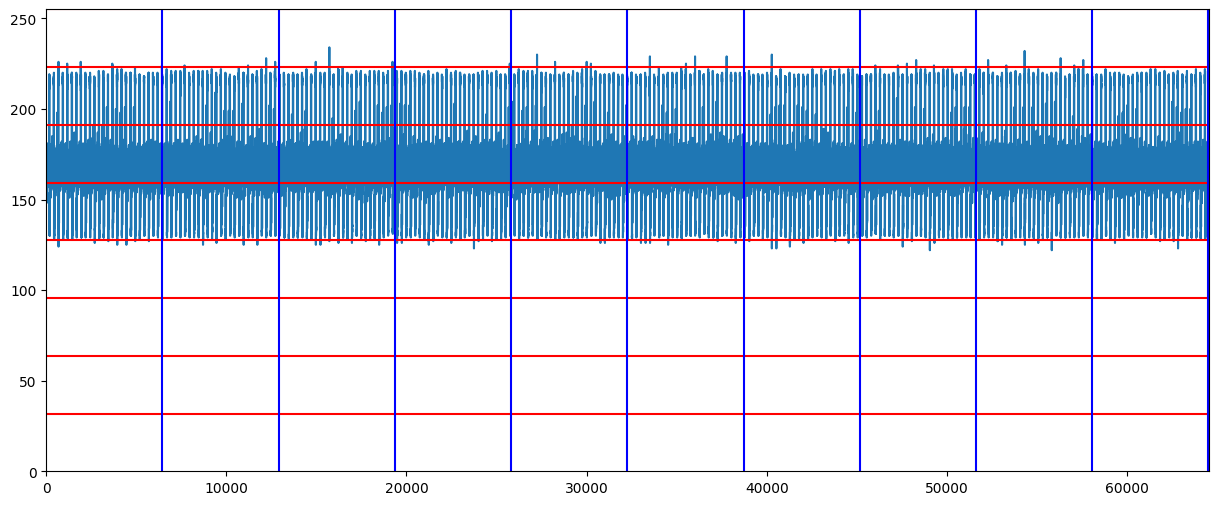

In [17]:
index=35
hor_points=int(len(saved_dat[index])/10) #calculate the lenght for each square in the time axis

#plot the acquiered data
plt.figure(figsize=(15,6))
plt.plot(saved_dat[index])
for a in range(1,9):
    plt.axhline(y = ((255*a)/8), color = 'r', linestyle = '-')
for a in range(1,11):
    plt.axvline(x = (hor_points*a), color = 'b', linestyle = '-')
plt.xlim([0,len(saved_dat[index])])
plt.ylim([0,255])
print(len(saved_dat[index]))